In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [2]:
from catboost import CatBoostRegressor, CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

/root/anaconda3/envs/cp/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics


def score_classifier_simple(target, predictions, threshold=0.5) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)
    response = (predictions > threshold).astype(int)

    metrics = {
        "roc_auc_score":   round((np.sqrt(roc_auc_score(target, predictions))),3),
        "av_precision_score": round((np.sqrt(average_precision_score(target, predictions))),3),
        "accuracy_score":  round(accuracy_score(target, response),3),
        "precision_score":  round(precision_score(target, response),3),
        "recall_score":   round((np.sqrt(recall_score(target, response))),3),
        "f1_score":       round(f1_score(target, response),3),
        "matthews_corrcoef":        round(matthews_corrcoef(target, response),3),
        } 
    return metrics

In [4]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

# SETUP

In [5]:
CONFIG_DIR = '../app/'

In [6]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [7]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-21'

In [8]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            'token_all_activity_3H': [0, 30],
            'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [9]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1664171973,40888,28680,sell,0x6b3b29f8d86d7f43132f92465337ff419c865cf3,NaN,0.74,sneakers,common,sprinter,...,542.0,8546.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,88.0,1.295374
1,1664171916,40887,28688,sell,0x1e716ebaaec5e99d5f43ed459f2d246ddc8e8bf4,NaN,0.76,sneakers,common,hiker,...,542.0,8546.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,88.0,1.295374
2,1664171871,40886,29273,sell,0x6e334353367b4e940bcd2f15f089b7b8e147c8bb,NaN,0.72,sneakers,common,sprinter,...,541.0,8546.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,88.0,1.300000
3,1664171856,40767,29273,cancel,0x6e334353367b4e940bcd2f15f089b7b8e147c8bb,NaN,NaN,sneakers,common,sprinter,...,542.0,8546.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,88.0,1.295374
4,1664171817,40885,35436,sell,0x07a26df21fb2bde24ba2e89bcc0233af9a371b63,NaN,0.70,sneakers,common,ranger,...,541.0,8547.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,88.0,1.291815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53835,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
53836,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
53837,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,904,0,252,1495,1831,2314,NaN,NaN
53838,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,15934,3984,256,4545,5225,15934,NaN,NaN


In [10]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [11]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53840 entries, 0 to 53839
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  37947 non-null  float64
 1   time_ownership             37947 non-null  float64
 2   wallet_box_mint            37947 non-null  float64
 3   wallet_sneaker_mint        37947 non-null  float64
 4   time_level_up              34835 non-null  float64
 5   time_level_up_for_mint     37947 non-null  float64
 6   base_mint_price_amt        37947 non-null  float64
 7   base_mint_price_azy        37947 non-null  float64
 8   base_mint_price_bnb        27924 non-null  float64
dtypes: float64(9)
memory usage: 3.7 MB


In [12]:
data.genesis

0         True
1         True
2         True
3         True
4        False
         ...  
53835     True
53836    False
53837    False
53838    False
53839     True
Name: genesis, Length: 53840, dtype: bool

In [13]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
31,1664171254,40868,44704,buy,0x21156333e5bfac34790d9a6a7adbd52ac891f99e,0xc726cbb097027052e51a02e472c80190afa76e51,0.72,sneakers,common,coacher,...,540.0,8545.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,88.0,1.303571
48,1664170621,40544,55019,buy,0xd521127549608dfe57029d2e32d720302c408cf9,0x9c1a977849a72206a3aa4645e2cfec1ddf29443c,0.74,sneakers,common,sprinter,...,541.0,8542.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,88.0,1.306050
56,1664170357,40413,20662,buy,0x0ac4ccf34f77327a8e0030f92cd0fb45c54c09b2,0x21f32b34c9282a9811ef221dccdf14ade433d96d,0.72,sneakers,common,hiker,...,543.0,8543.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,88.0,1.316726
67,1664169694,40811,50905,buy,0x845bd442ad9023f10e34dda1450e79f925446f21,0xf191581b3e5c7e2bd4fbfb838604b28b38264024,0.66,sneakers,common,sprinter,...,544.0,8543.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,88.0,1.315603
71,1664169592,40538,53611,buy,0x0027fbc35ce9bc0fdb938367c034ed4b993515a5,0xaade82990415ff43dc08760b6670f3caa8adbaad,0.74,sneakers,common,ranger,...,546.0,8543.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,88.0,1.314488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53777,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
53800,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
53814,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
53819,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


# data_quality

In [14]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

cancel_count_24H more then expected. get: 1129 | expected: 1000


In [15]:
data['mint'].isna().sum()

0

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9850 entries, 31 to 53833
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        9850 non-null   int64  
 1   mrk_id                                           9850 non-null   int64  
 2   token_id                                         9850 non-null   int64  
 3   event                                            9850 non-null   object 
 4   wallet_from                                      9850 non-null   object 
 5   wallet_to                                        9850 non-null   object 
 6   price                                            9850 non-null   float64
 7   item_type                                        9850 non-null   object 
 8   rarity                                           9850 non-null   object 
 9   sneaker_type                

In [17]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9850 entries, 31 to 53833
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  9850 non-null   float64
 1   time_ownership             9850 non-null   float64
 2   wallet_box_mint            9850 non-null   float64
 3   wallet_sneaker_mint        9850 non-null   float64
 4   time_level_up              9850 non-null   float64
 5   time_level_up_for_mint     9850 non-null   float64
 6   base_mint_price_amt        9850 non-null   float64
 7   base_mint_price_azy        9850 non-null   float64
 8   base_mint_price_bnb        7460 non-null   float64
dtypes: float64(9)
memory usage: 769.5 KB


In [18]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
31,1.657816e+09,1521341.0,7.0,7.0,900.0,1800.0,300.0,200.0,0.590190
48,1.663154e+09,417139.0,4.0,4.0,900.0,1800.0,300.0,200.0,0.592643
56,1.657810e+09,35554.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.592643
67,1.658142e+09,824670.0,8.0,10.0,900.0,1800.0,300.0,200.0,0.588841
71,1.663346e+09,27908.0,0.0,0.0,0.0,1800.0,300.0,200.0,0.589675
...,...,...,...,...,...,...,...,...,...
53777,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
53800,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
53814,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
53819,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [19]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [20]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [21]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [22]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9850 entries, 31 to 53833
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        9850 non-null   int64  
 1   mrk_id                                           9850 non-null   int64  
 2   token_id                                         9850 non-null   int64  
 3   event                                            9850 non-null   object 
 4   wallet_from                                      9850 non-null   object 
 5   wallet_to                                        9850 non-null   object 
 6   price                                            9850 non-null   float64
 7   item_type                                        9850 non-null   object 
 8   rarity                                           9850 non-null   object 
 9   sneaker_type                

In [24]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
31,1664171254,40868,44704,buy,0x21156333e5bfac34790d9a6a7adbd52ac891f99e,0xc726cbb097027052e51a02e472c80190afa76e51,0.72,sneakers,common,coacher,...,540.0,8545.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,88.0,1.303571
48,1664170621,40544,55019,buy,0xd521127549608dfe57029d2e32d720302c408cf9,0x9c1a977849a72206a3aa4645e2cfec1ddf29443c,0.74,sneakers,common,sprinter,...,541.0,8542.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,88.0,1.306050
56,1664170357,40413,20662,buy,0x0ac4ccf34f77327a8e0030f92cd0fb45c54c09b2,0x21f32b34c9282a9811ef221dccdf14ade433d96d,0.72,sneakers,common,hiker,...,543.0,8543.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,88.0,1.316726
67,1664169694,40811,50905,buy,0x845bd442ad9023f10e34dda1450e79f925446f21,0xf191581b3e5c7e2bd4fbfb838604b28b38264024,0.66,sneakers,common,sprinter,...,544.0,8543.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,88.0,1.315603
71,1664169592,40538,53611,buy,0x0027fbc35ce9bc0fdb938367c034ed4b993515a5,0xaade82990415ff43dc08760b6670f3caa8adbaad,0.74,sneakers,common,ranger,...,546.0,8543.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,88.0,1.314488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53777,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
53800,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
53814,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
53819,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


In [25]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [26]:
data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',])]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date
53344,1661076949,14027,23846,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7bdf18948f2b640ba7fea97875849038bd43da2c,0.73,sneakers,common,sprinter,...,NaN,16182,4070,391,4746,5443,16182,NaN,NaN,2022-08-21 10:15:49
53293,1661079343,14070,20408,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7dd69ca014565e2c9e1b47beabf57a4469d51fe1,0.73,sneakers,common,sprinter,...,NaN,16191,4072,387,4748,5448,16191,NaN,NaN,2022-08-21 10:55:43
53090,1661087557,14094,26385,buy,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0x06333746416b07371d84d1f862a352ec7ca1ab10,1.16,sneakers,common,hiker,...,NaN,16227,4332,384,4770,5469,16227,NaN,NaN,2022-08-21 13:12:37
52895,1661095945,14208,16352,buy,0xec04f1a68a3618028f3431ccf570508d95d34dce,0x3ae4020278e724bec4d24135bf9d42b6879a648f,0.69,sneakers,common,sprinter,...,NaN,16258,4083,380,4791,5492,16258,NaN,NaN,2022-08-21 15:32:25
52164,1661155769,14662,31425,buy,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0xf1a560df54f04b45e756d1cb36241fec633134a2,0.70,sneakers,common,sprinter,...,NaN,16415,4126,251,4875,5592,16415,NaN,NaN,2022-08-22 08:09:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,1664146652,40601,52435,buy,0x8ce811213d833bdc2f33ad33d219a54e4bc1699d,0xf90d11201af7f83a6f222311507a1d2696b02526,0.68,sneakers,common,ranger,...,8531.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,89.0,1.298305,2022-09-25 22:57:32
318,1664159144,40713,36743,buy,0x57be29af105f5b9cfb7cbcc1fc4a22bd453215c2,0x144438f723a3aa5f29046934376211cdb74fd1b6,0.63,sneakers,common,hiker,...,8541.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,89.0,1.332180,2022-09-26 02:25:44
292,1664160011,40678,29833,buy,0x8109ddb2277068a597cc9511e94f288b4f72e36c,0x144438f723a3aa5f29046934376211cdb74fd1b6,0.69,sneakers,common,hiker,...,8541.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,89.0,1.305556,2022-09-26 02:40:11
277,1664160530,40715,39089,buy,0xf7c17d1ccbabcca9d178f61f0b327bf5143e747a,0xa97fbca8d68c1e4b4749b60cea4cdbb79c2990f5,0.67,sneakers,common,hiker,...,8541.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,88.0,1.306620,2022-09-26 02:48:50


In [27]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [28]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [29]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [30]:
data['token_sell_activity_6H'].max()

11

In [31]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [32]:
# Перекуп датасет

dupl_df = data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',], keep=False)]

In [33]:
data[data['token_id'] == 34874]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date,sum_activity_24H,sells_activity_24H
38680,1662138884,21406,34874,buy,0x92ede55a13c314bc7ca513734240d5d751b73008,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,1.07,sneakers,common,coacher,...,3942,323,1584,4052,13161,NaN,NaN,2022-09-02 17:14:44,1654,1.869180
34442,1662430561,23510,34874,buy,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,0x3273af210822c44afd7254510e612e4dbb1040a7,0.97,sneakers,common,coacher,...,4018,287,2007,3803,9987,NaN,NaN,2022-09-06 02:16:01,1079,2.341772


In [34]:
len(dupl_df)

2360

In [35]:
count_list = []
final_df = pd.DataFrame()

for token_id in dupl_df['token_id'].unique():
    data_tmp = dupl_df[dupl_df['token_id'] == token_id]
    #if data_tmp.iloc[0]['wallet_to'] == data_tmp.iloc[1]['wallet_from']:
    #print(len(data_tmp))
    i=0
    #for i in range(len(data_tmp)-1):
        #print(i)
    sample = data_tmp.iloc[i].copy()
    sample['sell_wallet_from'] = data_tmp.iloc[i+1]['wallet_from']
    sample['sell_price'] = data_tmp.iloc[i+1]['price']
    sample['sell_data'] = data_tmp.iloc[i+1]['date']
    sample['profit'] = (data_tmp.iloc[i+1]['price'] - ((data_tmp.iloc[i+1]['price']/100) * 5)) - data_tmp.iloc[i]['price']
    final_df = pd.concat([final_df, sample], ignore_index=True, sort=False, axis=1)
    
    #break

In [36]:
final_df = final_df.T
final_df

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit
0,1661065858,13953,31752,buy,0x8109ddb2277068a597cc9511e94f288b4f72e36c,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.76,sneakers,common,sprinter,...,16155,NaN,NaN,2022-08-21 07:10:58,911,4.683168,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.9,2022-09-02 20:03:07,0.095
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,16168,NaN,NaN,2022-08-21 08:19:31,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,16169,NaN,NaN,2022-08-21 08:20:10,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935
3,1661079088,14089,26385,buy,0x25ad8afeb7b5c119fdbabb2ec99f84a611caea2a,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0.8,sneakers,common,hiker,...,16191,NaN,NaN,2022-08-21 10:51:28,978,4.469027,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,1.16,2022-08-21 13:12:37,0.302
4,1661082994,14081,26390,buy,0x627afb1341cb1ae3cb3546424709dba42d88bde9,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.72,sneakers,common,sprinter,...,16204,NaN,NaN,2022-08-21 11:56:34,998,4.557522,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.7,2022-08-29 16:25:54,-0.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,1664117324,40026,15367,buy,0x00a76804cab86f32ee98e2a17ec633a9090b5b5c,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.7,sneakers,common,sprinter,...,count_new_sneaker_30d,101.0,1.337705,2022-09-25 14:48:44,2064,3.606061,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.82,2022-09-25 20:40:05,0.079
1081,1664130018,40275,23732,buy,0x001f581ca7fb3a01bd2c7ef4577e1bf22e15e7c0,0x65b7ee848d586fe8f82fc77a99e57f35562cd33f,0.62,sneakers,common,sprinter,...,count_new_sneaker_30d,97.0,1.285714,2022-09-25 18:20:18,2327,4.147766,0x65b7ee848d586fe8f82fc77a99e57f35562cd33f,0.73,2022-09-25 21:15:59,0.0735
1082,1664130114,40278,23764,buy,0x001f581ca7fb3a01bd2c7ef4577e1bf22e15e7c0,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.62,sneakers,common,sprinter,...,count_new_sneaker_30d,97.0,1.277966,2022-09-25 18:21:54,2334,4.129693,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.69,2022-09-25 18:49:09,0.0355
1083,1664130360,40282,53611,buy,0x847b3f8f2c083fe8069426ea4980fc25aac81c5d,0x0027fbc35ce9bc0fdb938367c034ed4b993515a5,0.64,sneakers,common,ranger,...,count_new_sneaker_30d,97.0,1.281356,2022-09-25 18:26:00,2339,4.12585,0x0027fbc35ce9bc0fdb938367c034ed4b993515a5,0.74,2022-09-26 05:19:52,0.063


In [37]:
final_df.profit.median()

0.025999999999999912

In [38]:
final_df.profit.sum()

7.946724999999995

In [39]:
len(final_df.groupby('wallet_to')['profit'].sum())

330

In [40]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 0).sum()

154

In [41]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 1).sum()

15

In [42]:
final_df.groupby('wallet_to')['profit'].sum().sort_values()

wallet_to
0xe58ea7792930a4b52b4b4701b88ec709b205c54d   -8.459425
0xee17c73127c83d876758f8750fd4c81710673d2b     -7.3965
0x4a37b679463b90481547956da5b0432d45c867a5      -6.836
0x5eddc3624cf47c37eb7f056ab23150e502341d0a     -6.8065
0xda9f0564c09479c9c54e653b05c47bfe663952a6        -5.2
                                                ...   
0xee731ff68f1b70358d4220eb964ed39feb89c6d9      2.3855
0xff06dbe17724093ce542247b28beef42dedb9f4b      4.3415
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba      4.5595
0xf3df1c64cb2e66400ef968caabfbe665457d25d4      8.7315
0x3273af210822c44afd7254510e612e4dbb1040a7      18.916
Name: profit, Length: 330, dtype: object

In [43]:
(final_df.wallet_to.value_counts() > 1).sum()

133

In [44]:
# фильтр по количеству сделок
len(final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10])

10

In [45]:
select_wallets = final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()

In [46]:
len(final_df)

408

In [47]:
# фильтр только прибыльных торгошей
final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].sort_values()

wallet_to
0xff06dbe17724093ce542247b28beef42dedb9f4b    4.3415
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba    4.5595
0xf3df1c64cb2e66400ef968caabfbe665457d25d4    8.7315
0x3273af210822c44afd7254510e612e4dbb1040a7    18.916
Name: profit, dtype: object

In [48]:
select_wallets = final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()
len(final_df)

241

In [49]:
final_df['sell_time'] = ((final_df['sell_data'] - final_df['date']) / np.timedelta64(1,'h')).astype(int)

In [50]:
final_df['sell_time']

1        1
2        2
28      11
52      51
55      57
        ..
1052    18
1064     0
1071     2
1077     6
1080     5
Name: sell_time, Length: 241, dtype: int64

In [51]:
final_df['target'] = final_df['profit']

In [52]:
final_df['target'].max()

5.577

In [53]:
final_df['target'].min()

-2.6075000000000004

# Model

In [54]:
data = final_df.copy()

In [55]:
int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint', 'buy_count_12H',
    'buy_count_24H','sum_activity_24H','token_all_activity_3H',
    'token_sell_activity_6H','time_level_up']
float_columns = ['base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability', 'price', 'min_price_all_24H',
    'sells_activity_24H',
    'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H','profit', 
    'base_mint_price_amt',
    'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    'price_azy', 
    'price_amt',
    'target']
cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [56]:
for columns in int_columns:
    data[columns] = data[columns].astype('int')

for columns in float_columns:
    data[columns] = data[columns].astype('float')

for columns in cat_columns:
    data[columns] = data[columns].astype('category')

In [57]:
data['genesis'] = data['genesis'].astype('bool')

In [58]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)
predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 3)
data['predict'] = predict_price
#predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [59]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 2)
data['predict_base'] = predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [60]:
data['profit_by_predict_model'] = np.round((data['predict'] - ((data['predict']/100) * 5)) - data['price'], 3)

In [61]:
data['profit_by_predict_base_model'] = np.round((data['predict_base'] - ((data['predict_base']/100) * 5)) - data['price'], 3)

In [62]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit,sell_time,target,profit_by_predict_model,profit_by_predict_base_model
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.50,sneakers,common,sprinter,...,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935,1,0.1935,0.241,0.355
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.50,sneakers,common,sprinter,...,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935,2,0.1935,0.248,0.402
28,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,1030,4.645455,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,7.66,2022-08-23 05:20:37,5.5770,11,5.5770,3.334,5.244
52,1661330758,15771,14732,buy,0x50246a336021f120dc42a694d574f6fa593c130f,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.70,sneakers,common,sprinter,...,938,3.081633,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.82,2022-08-26 12:24:47,0.0790,51,0.0790,0.048,0.165
55,1661342057,15841,24003,buy,0xbf4296b6e85d8aa032c091edf006bf5fe3f3b5b3,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.68,sneakers,common,sprinter,...,917,3.020000,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.85,2022-08-26 21:45:51,0.1275,57,0.1275,0.066,0.175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,1663968122,38286,52298,buy,0x57e92dbbff9fd26e16eb554935863c03665fc720,0x3273af210822c44afd7254510e612e4dbb1040a7,0.80,sneakers,common,ranger,...,1618,3.152416,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.95,2022-09-24 16:17:58,0.1025,18,0.1025,0.108,0.150
1064,1664025474,38771,51259,buy,0x093304f7d6ca5f9a834b9cf0de7332b296e36d0a,0x3273af210822c44afd7254510e612e4dbb1040a7,0.70,sneakers,common,sprinter,...,1461,2.885375,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.77,2022-09-24 13:30:06,0.0315,0,0.0315,0.304,0.326
1071,1664034934,38935,58754,buy,0x919938c67fda32f3c64477c56679a32b93503dd8,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.73,sneakers,common,ranger,...,1564,3.034884,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.85,2022-09-24 18:00:04,0.0775,2,0.0775,0.038,0.172
1077,1664111651,39871,31818,buy,0xb794ed9c41014eaa74be9a8ede0b8f287c5999a3,0x3273af210822c44afd7254510e612e4dbb1040a7,0.79,sneakers,common,hiker,...,2001,3.577320,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.84,2022-09-25 19:52:12,0.0080,6,0.0080,0.031,0.188


In [63]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

145

In [64]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [65]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [66]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
463,276.798229,0.111966,0.519497,1659203035.0,1125777.0,2.0,3.0,60,1800.0,300.0,200.0,0.643943,2022-09-03 07:06:55
464,276.883697,0.111953,0.516913,1660744494.0,150.0,0.0,0.0,900,1800.0,300.0,200.0,0.640935,2022-09-03 07:33:34
467,276.171518,0.111510,0.521967,1659438695.0,216.0,3.0,3.0,900,1800.0,300.0,200.0,0.647758,2022-09-03 08:35:22
475,277.109304,0.099167,0.552721,1658162819.0,519011.0,7.0,10.0,900,1800.0,300.0,200.0,0.669951,2022-09-03 13:00:04
476,277.268066,0.100288,0.550715,1659438695.0,273.0,3.0,3.0,900,1800.0,300.0,200.0,0.668205,2022-09-03 13:18:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,268.570938,0.074905,0.546235,1657809469.0,102.0,7.0,7.0,0,1800.0,300.0,200.0,0.665937,2022-09-20 19:20:06
969,269.303511,0.075930,0.548157,1657800147.0,33.0,8.0,7.0,1680,1800.0,300.0,200.0,0.667028,2022-09-20 19:55:45
971,268.344579,0.074641,0.548387,1657819349.0,4142296.0,5.0,5.0,900,1800.0,300.0,200.0,0.668709,2022-09-20 20:54:28
973,268.406821,0.074181,0.548455,1657810951.0,3056643.0,6.0,5.0,900,1800.0,300.0,200.0,0.668287,2022-09-20 20:59:52


In [67]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 463 to 980
Data columns (total 86 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   timestamp                                        145 non-null    int64         
 1   mrk_id                                           145 non-null    int64         
 2   token_id                                         145 non-null    int64         
 3   event                                            145 non-null    object        
 4   wallet_from                                      145 non-null    object        
 5   wallet_to                                        145 non-null    object        
 6   price                                            145 non-null    float64       
 7   item_type                                        145 non-null    category      
 8   rarity                                

In [68]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    # 'base_performance',
    # 'base_fortune',
    # 'base_joy',
    # 'base_durability',
    # 'performance',
    # 'fortune',
    # 'joy',
    # 'durability',
    'mint',
    #'buy_count_12H',
    #'buy_count_24H',
    #'min_price_all_24H',
    #'sum_activity_24H',
    #'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    #'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    'price',
    #'sell_price',
    #'profit',
    #'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    #'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'predict',
    #'predict_base',
    'profit_by_predict_model',
    'profit_by_predict_base_model',
    ]
cat_features = [0, 1, 2,]

In [69]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.target.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.target.copy().reset_index(drop=True)

In [70]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        depth=3,
        #learning_rate=0.01,
        #iterations=1000,
        loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  2.64it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:00,  2.69it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:01,  3.00it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:01,  2.81it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:01,  2.76it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:02,  2.92it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:02,  2.91it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:02,  2.95it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:03,  3.06it/s]iteritems is deprec

In [71]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.432,0.4078
MAE,0.082,0.0636
MSE,0.061,0.1582
RMSE,0.155,0.1967
MAPE,0.826,0.4063


In [72]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.432,0.4078
MAE,0.082,0.0636
MSE,0.061,0.1582
RMSE,0.155,0.1967
MAPE,0.826,0.4063


In [73]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.226, 'MAE': 0.082, 'MSE': 0.061, 'RMSE': 0.246, 'MAPE': 0.823}

In [74]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


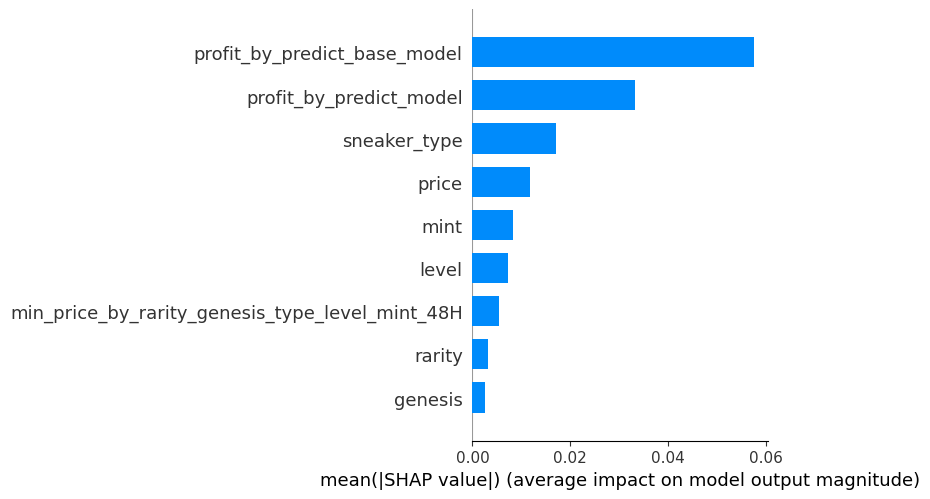

In [75]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [76]:
model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

0:	learn: 0.1069415	total: 322us	remaining: 322ms
1:	learn: 0.1060115	total: 735us	remaining: 367ms
2:	learn: 0.1050203	total: 1.09ms	remaining: 363ms
3:	learn: 0.1040117	total: 1.36ms	remaining: 339ms
4:	learn: 0.1030980	total: 1.66ms	remaining: 329ms
5:	learn: 0.1019659	total: 1.93ms	remaining: 319ms
6:	learn: 0.1012084	total: 2.18ms	remaining: 309ms
7:	learn: 0.1004552	total: 2.44ms	remaining: 303ms
8:	learn: 0.0993197	total: 2.71ms	remaining: 298ms
9:	learn: 0.0985324	total: 2.99ms	remaining: 296ms
10:	learn: 0.0974180	total: 3.23ms	remaining: 290ms
11:	learn: 0.0967395	total: 3.83ms	remaining: 315ms
12:	learn: 0.0957728	total: 10.8ms	remaining: 819ms
13:	learn: 0.0946710	total: 11ms	remaining: 778ms
14:	learn: 0.0939497	total: 11.3ms	remaining: 741ms
15:	learn: 0.0935510	total: 11.5ms	remaining: 709ms
16:	learn: 0.0922644	total: 11.8ms	remaining: 680ms
17:	learn: 0.0919431	total: 12ms	remaining: 652ms
18:	learn: 0.0910844	total: 12.2ms	remaining: 629ms
19:	learn: 0.0906229	total: 

In [77]:
pred = model.predict(X_test)
pred = np.round(pred, 3)

score = score_regression_simple(y_test, pred,)
score

{'R2': -0.347,
 'MAE': 0.065,
 'MSE': 0.008,
 'RMSE': 0.088,
 'MAPE': 18014398509483.74}

In [78]:
submission = pd.DataFrame()
submission['profit'] = test_data.profit.copy().reset_index(drop=True)
submission['pred'] = pred

In [79]:
submission.profit.sum()

3.041500000000001

In [80]:
submission

,profit,pred
0,0.2680,0.400
1,0.1355,0.082
2,0.0605,0.163
3,0.1255,0.124
4,0.0655,0.097
5,0.1735,0.159
6,0.0305,0.157
7,0.2700,0.322
8,0.0000,0.116
9,0.1260,0.141


In [81]:
submission[submission['pred'] > 0.05].profit.sum()

3.0515000000000008

In [82]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': -0.358,
 'MAE': 0.065,
 'MSE': 0.008,
 'RMSE': 0.089,
 'MAPE': 18635584664983.13}

## Fit full Model

In [83]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_profit_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


0:	learn: 0.0992199	total: 408us	remaining: 408ms
1:	learn: 0.0984001	total: 2.87ms	remaining: 1.43s
2:	learn: 0.0975062	total: 3.47ms	remaining: 1.15s
3:	learn: 0.0965426	total: 4.13ms	remaining: 1.03s
4:	learn: 0.0955783	total: 4.41ms	remaining: 877ms
5:	learn: 0.0946664	total: 4.76ms	remaining: 789ms
6:	learn: 0.0942191	total: 5.08ms	remaining: 721ms
7:	learn: 0.0937378	total: 5.42ms	remaining: 673ms
8:	learn: 0.0932300	total: 5.73ms	remaining: 631ms
9:	learn: 0.0922966	total: 6.21ms	remaining: 615ms
10:	learn: 0.0915647	total: 6.59ms	remaining: 592ms
11:	learn: 0.0911149	total: 6.94ms	remaining: 571ms
12:	learn: 0.0904824	total: 7.32ms	remaining: 555ms
13:	learn: 0.0899762	total: 7.64ms	remaining: 538ms
14:	learn: 0.0897383	total: 7.93ms	remaining: 521ms
15:	learn: 0.0888070	total: 8.23ms	remaining: 506ms
16:	learn: 0.0877586	total: 8.5ms	remaining: 492ms
17:	learn: 0.0873011	total: 8.84ms	remaining: 482ms
18:	learn: 0.0867722	total: 13.5ms	remaining: 697ms
19:	learn: 0.0863709	tot

In [84]:
y

0      0.0770
1      0.0455
2      0.1740
3      0.3305
4      0.0685
        ...  
169    0.1025
170    0.0315
171    0.0775
172    0.0080
173    0.0790
Name: target, Length: 174, dtype: float64

### Test

In [85]:
i=102

In [86]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sneaker_dict

{'timestamp': 1663061828,
 'mrk_id': 28651,
 'token_id': 41385,
 'event': 'buy',
 'wallet_from': '0x6d3489da64a34663c54500aee7a748f1efe4d576',
 'wallet_to': '0x3273af210822c44afd7254510e612e4dbb1040a7',
 'price': 0.87,
 'item_type': 'sneakers',
 'rarity': 'common',
 'sneaker_type': 'coacher',
 'level': 5,
 'base_performance': 2.5,
 'base_fortune': 7.2,
 'base_joy': 6.4,
 'base_durability': 5.2,
 'performance': 19.0,
 'fortune': 10.7,
 'joy': 9.4,
 'durability': 7.7,
 'mint': 2,
 'parent1': 37592.0,
 'parent2': 38844.0,
 'genesis': False,
 'parent1_sneaker_type': 'hiker',
 'parent2_sneaker_type': 'sprinter',
 'price_bnb': 293.08856531,
 'price_azy': 0.08815466,
 'price_amt': 0.54666385,
 'wallet_from_buy_count': 6,
 'wallet_from_all_count': 33,
 'token_all_activity_3H': 1,
 'token_sell_activity_6H': 1,
 'buy_count_12H': 60,
 'buy_count_24H': 290,
 'buy_count_48H': 524,
 'sell_count_12H': 223,
 'sell_count_24H': 682,
 'sell_count_48H': 1225,
 'cancel_count_12H': 115,
 'cancel_count_24H':

In [87]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [88]:
pd.Series(sneaker_dict)[model.feature_names_]

rarity                                              common
sneaker_type                                       coacher
genesis                                              False
level                                                    5
mint                                                     2
min_price_by_rarity_genesis_type_level_mint_48H       0.69
price                                                 0.87
profit_by_predict_model                             -0.066
profit_by_predict_base_model                        -0.034
dtype: object

In [89]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_profit_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

-0.023

In [90]:
data.iloc[i]['profit']

-0.0625

iteritems is deprecated and will be removed in a future version. Use .items instead.


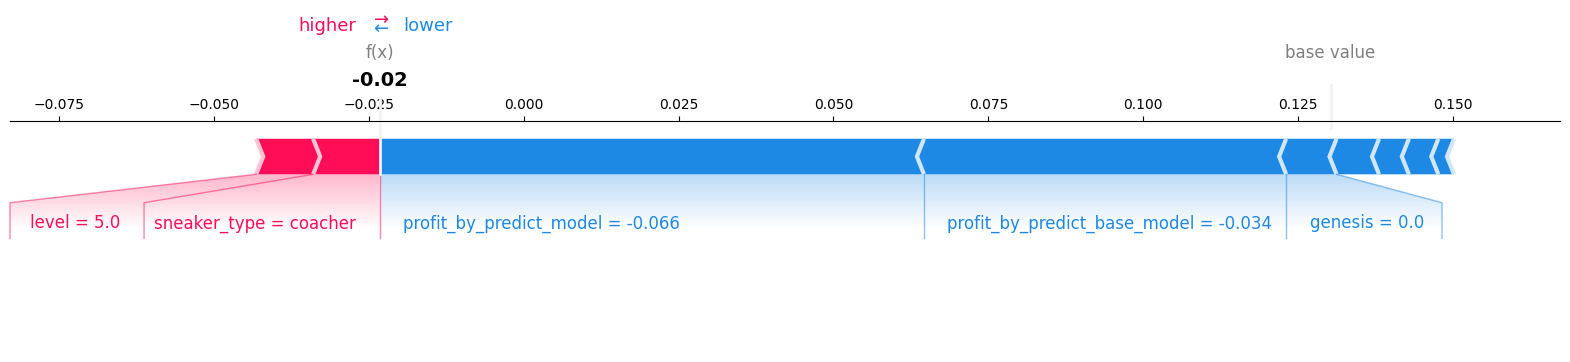

In [91]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)